In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from mat6115.hidden import run_and_save_hidden, get_hidden
from mat6115.dataset import dataset_factory, TEXT, LABEL, SEED
from mat6115.model import RNN
from mat6115.train import custom_loss, acc
from mat6115.fixed_point import FixedPointFinder
from mat6115.analysis import load_model
from poutyne.framework import Model
import torch
from torch import nn
from pathlib import Path
import pickle
import json
plt.style.use('seaborn')
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
train_iter, valid_iter, test_iter = dataset_factory("imdb", embedding="glove.6B.100d")

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
num_layers = 2

SAVE_PATH = Path(f'gru_{num_layers}layer')
vanilla_model = load_model(SAVE_PATH)
trained_model = load_model(SAVE_PATH, restore=True)

vanilla_model.to(device)
trained_model.to(device)

/home/alexis/miniconda3/envs/mat6115/lib/python3.8/site-packages/torch/nn/modules/rnn.py:47: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [23]:
import spacy
nlp = spacy.load('en')

def predict_sentiment(model, sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    length_tensor = torch.LongTensor(length)
    prediction = model.predict((tensor, length_tensor), batch_size=1)
    return 1 * LABEL.vocab.stoi['neg'] - 1 / (1 + np.exp(-prediction[0]))

In [24]:
def hidden_state_for_text(model, sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    length_tensor = torch.LongTensor(length)
    return model.predict((tensor, length_tensor), batch_size=1)[1].squeeze(0)

In [25]:
predict_sentiment(trained_model, "This film is terrible")

array([0.06102628], dtype=float32)

In [26]:
predict_sentiment(vanilla_model, "This film is terrible")

array([0.5180706], dtype=float32)

### Load artifacts

In [27]:
pca_vanilla = []
pca_trained = []

pca_vanilla_2 = []
pca_trained_2 = []

vanilla_data, trained_data = [], []
fixed_point = []

with open(SAVE_PATH/"vanilla_ground_truth.npy", "rb") as f:
    vanilla_ground_truth = np.load(f)

with open(SAVE_PATH/"trained_ground_truth.npy", "rb") as f:
    trained_ground_truth = np.load(f)
        


for i in range(num_layers):
    with open(SAVE_PATH/f"{i+1}/pca_trained.pkl", "rb") as f:
        pca_trained.append(pickle.load(f))

    with open(SAVE_PATH/f"{i+1}/pca_vanilla.pkl", "rb") as f:
        pca_vanilla.append(pickle.load(f))

    with open(SAVE_PATH/f"{i+1}/pca_trained_n2.pkl", "rb") as f:
        pca_trained_2.append(pickle.load(f))

    with open(SAVE_PATH/f"{i+1}/pca_vanilla_n2.pkl", "rb") as f:
        pca_vanilla_2.append(pickle.load(f))
        
    with open(SAVE_PATH/f"{i+1}/transformed_vanilla_n2.npy", "rb") as f:
        vanilla_data.append(np.load(f))

    with open(SAVE_PATH/f"{i+1}/transformed_trained_n2.npy", "rb") as f:
        trained_data.append(np.load(f))

    with open(SAVE_PATH/f"{i+1}/unique_fixed_points.npy", "rb") as f:
        fixed_point.append(np.load(f))

## Plotting

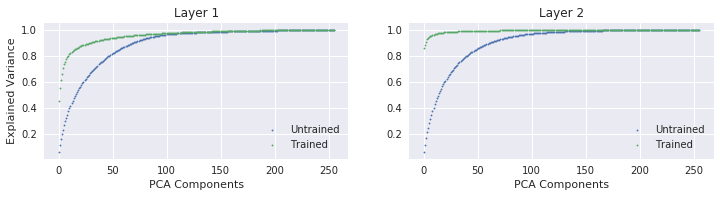

In [28]:
fig, ax = plt.subplots(
    1, num_layers, 
    figsize=(6 * num_layers, 2.5)
)
if num_layers == 1:
    ax = [ax]

ax[0].set_ylabel('Explained Variance')
for i in range(num_layers):
    ax[i].scatter(
        np.arange(len(pca_vanilla[i].explained_variance_ratio_)),
        pca_vanilla[i].explained_variance_ratio_.cumsum(),
        s=2,
    )
    ax[i].scatter(
        np.arange(len(pca_trained[i].explained_variance_ratio_)),
        pca_trained[i].explained_variance_ratio_.cumsum(),
        s=2,
    )
    ax[i].set_xlabel('PCA Components')
    ax[i].legend(['Untrained', 'Trained'])
    ax[i].set_title(f'Layer {i+1}')

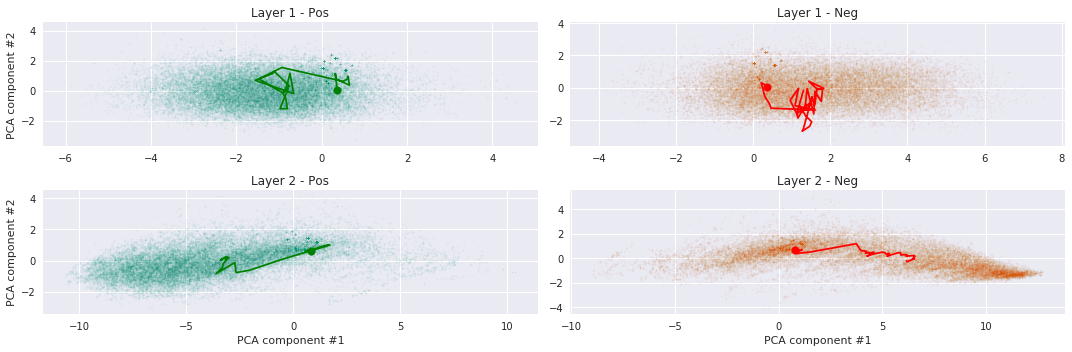

In [30]:
fig, ax = plt.subplots(num_layers, 2, figsize=(15, 2.5*num_layers))
pos_idx = vanilla_ground_truth == LABEL.vocab.stoi['pos']
neg_idx = vanilla_ground_truth == LABEL.vocab.stoi['neg']
GREEN = "#009E73"
RED = "#D55E00"


pos_text_hidden_states = hidden_state_for_text(
    trained_model, 
    (
        "It is by far one of the best comic book adaptations ever. "
        "I liked this one even more than X-men."
    )
)
neg_text_hidden_states = hidden_state_for_text(
    trained_model, 
    (
        "First of all I hate those moronic rappers, who couldn't act if they had "
         "a gun pressed against their foreheads. All they do is curse and shoot "
         "each other and acting like cliché'e version of gangsters."
    )
)

if num_layers == 1:
    ax = [ax]
for i in range(num_layers):
    ax1 = ax[i][0]
    ax2 = ax[i][1]
    
    ax1.scatter(trained_data[i][pos_idx, 0], trained_data[i][pos_idx, 1], c=GREEN, alpha=0.05, s=2)
    ax1.set_title(f'Layer {i+1} - Pos')
    ax1.set_ylabel("PCA component #2")

    ax2.scatter(trained_data[i][neg_idx, 0], trained_data[i][neg_idx, 1], c=RED, alpha=0.05, s=2)
    ax2.set_title(f'Layer {i+1} - Neg')
    
    pos = pca_trained_2[i].transform(pos_text_hidden_states[i])
    neg = pca_trained_2[i].transform(neg_text_hidden_states[i])
    
    ax1.plot(pos[:, 0], pos[:, 1], c='g')
    ax2.plot(neg[:, 0], neg[:, 1], c='r')
    
    # Splot starting point
    ax1.scatter(pos[0, 0], pos[0, 1], c='g', s=60)
    ax2.scatter(neg[0, 0], neg[0, 1], c='r', s=60)
    
ax1.set_xlabel("PCA component #1")
ax2.set_xlabel("PCA component #1")
plt.tight_layout()

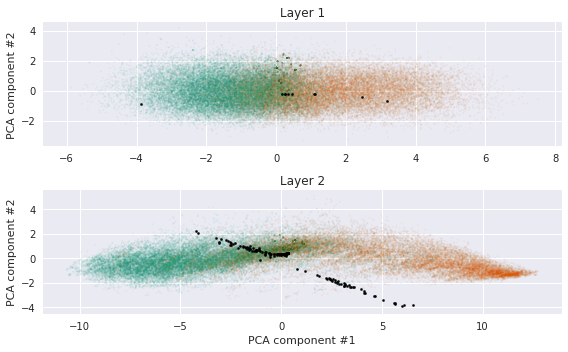

In [31]:
fig, ax = plt.subplots(num_layers, 1, figsize=(8, 2.5*num_layers))
colors = np.array([GREEN] * len(trained_ground_truth))
colors[trained_ground_truth == LABEL.vocab.stoi['neg']] = RED

GREY = "#111111"

if num_layers == 1:
    ax = [ax]
for i in range(num_layers):
    fp = pca_trained_2[i].transform(fixed_point[i])
    
    ax_ = ax[i]
    ax_.scatter(trained_data[i][:, 0], trained_data[i][:, 1], c=colors, alpha=0.05, s=2)
    ax_.scatter(fp[:,0], fp[:,1], c='k', s=5)
    ax_.set_title(f'Layer {i+1}')
    ax_.set_ylabel("PCA component #2")
    

ax_.set_xlabel("PCA component #1")
plt.tight_layout()

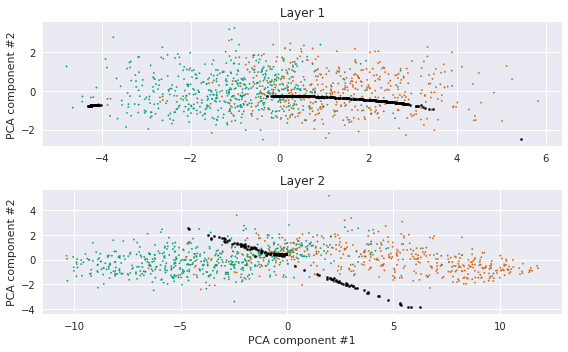

In [12]:
fig, ax = plt.subplots(num_layers, 1, figsize=(8, 2.5*num_layers))
colors = np.array([GREEN] * len(trained_ground_truth))
colors[trained_ground_truth == LABEL.vocab.stoi['neg']] = RED

GREY = "#111111"

if num_layers == 1:
    ax = [ax]
for i in range(num_layers):
    fp = pca_trained_2[i].transform(fixed_point[i])
    
    ax_ = ax[i]
    ax_.scatter(trained_data[i][:, 0], trained_data[i][:, 1], c=colors, alpha=1, s=2)
    ax_.scatter(fp[:,0], fp[:,1], c='k', s=5)
    ax_.set_title(f'Layer {i+1}')
    ax_.set_ylabel("PCA component #2")
    

ax_.set_xlabel("PCA component #1")
plt.tight_layout()